In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import serial
from time import sleep

In [2]:
def plotPosition(x1,
                 y1,
                 x0=0,
                 y0=0,
                 source: bool = False,
                 ax=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot([x0, x1], [y0, y1], c='k')
    if source:
        ax.scatter([x0], [y0], c='g', s=200)
    else:
        ax.scatter([x0], [y0], c='r')
    return ax

In [3]:
class plotBot(object):
    def __init__(self,
                 inner_length: float = 41,
                 outer_length: float = 44,
                 distance_between_origins: float = 24,
                 x_origin: float = 22,
                 y_origin: float = -26):

        self.INNER_LENGTH = inner_length
        self.OUTER_LENGTH = outer_length
        self.DISTANCE_BETWEEN_ORIGINS = distance_between_origins
        self.X_ORIGIN = x_origin #: from origin to first motor
        self.Y_ORIGIN = y_origin #: from origin to first motor

        self.current_x = 0
        self.current_y = 0
    
    def set_position(self, 
                     x: float,
                     y: float):
        self.current_x = x
        self.current_y = y
        
    def get_left_angle(self):
        x = self.current_x - self.X_ORIGIN
        y = self.current_y - self.Y_ORIGIN

        r2 = x ** 2 + y ** 2
        r = r2 ** 0.5
        theta2 = np.arccos((r2 - self.INNER_LENGTH ** 2 - self.OUTER_LENGTH ** 2) / (2 * self.INNER_LENGTH * self.OUTER_LENGTH))

        return np.arcsin(self.OUTER_LENGTH * np.sin(theta2) / r) + np.arctan2(y, x)
    
    def get_left_positions(self):
        theta = self.get_left_angle()
        
        x_motor = self.X_ORIGIN
        y_motor = self.Y_ORIGIN
        
        x = self.INNER_LENGTH * np.cos(theta) + x_motor
        y = self.INNER_LENGTH * np.sin(theta) + y_motor
        
        array = [
            (x_motor, y_motor),
            (x, y),
            (self.current_x, self.current_y)
        ]
        
        return np.array(array)
    
    def get_right_angle(self):
        x = self.current_x - (self.X_ORIGIN + self.DISTANCE_BETWEEN_ORIGINS)
        y = self.current_y - self.Y_ORIGIN

        r2 = x ** 2 + y ** 2
        r = r2 ** 0.5
        theta2 = np.arccos((r2 - self.INNER_LENGTH ** 2 - self.OUTER_LENGTH ** 2) / (2 * self.INNER_LENGTH * self.OUTER_LENGTH))

        return np.arctan2(y, x) - np.arcsin(self.OUTER_LENGTH * np.sin(theta2) / r)
    
    def get_right_positions(self):
        theta = self.get_right_angle()
        
        x_motor = self.X_ORIGIN + self.DISTANCE_BETWEEN_ORIGINS
        y_motor = self.Y_ORIGIN
        
        x = self.INNER_LENGTH * np.cos(theta) + x_motor
        y = self.INNER_LENGTH * np.sin(theta) + y_motor
        
        array = [
            (x_motor, y_motor),
            (x, y),
            (self.current_x, self.current_y)
        ]
        
        return np.array(array)

In [4]:
pb = plotBot()

137.37551768056105 117.17070972704984


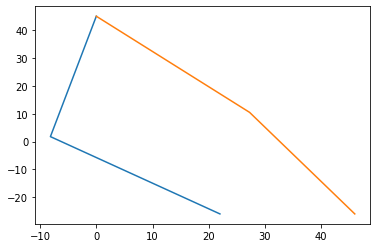

In [10]:
pb.set_position(0, 45)
theta_left = np.rad2deg(pb.get_left_angle())
theta_right = np.rad2deg(pb.get_right_angle())

left_arm = pb.get_left_positions()
right_arm = pb.get_right_positions()

print(theta_left, theta_right)

plt.plot(*left_arm.T)
plt.plot(*right_arm.T)

In [36]:
plotBot = serial.Serial(port='/dev/ttyUSB1', baudrate=9600, timeout=0.5)
for i in np.arange(45, 0, -5):
    x = np.arange(0, 60, 2)
    if i % 2 == 0:
        x = x[::-1]
    
    for j in x:
        txt = "X{} Y{} Z1".format(j, i)
        plotBot.write(txt.encode())
        line = plotBot.readline()
        if not line:
            print('Too fast')
            sleep(0.05)
plotBot.close()